In [1]:
import random
import numpy as np
from readRSF import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from pickle import dumps, loads
from tile_dataset import tile, merge
from keras.models import load_model

Using TensorFlow backend.


In [2]:
patch_num = 1000
patch_size = 64
val_split = 0.2

In [3]:
with open("objects/remigScaleModel.bin","rb+") as arq:
    objectBinaryDump = arq.read()
    remigScaleModel = loads(objectBinaryDump)

with open("objects/migScaleModel.bin","rb+") as arq:
    objectBinaryDump = arq.read()
    migScaleModel = loads(objectBinaryDump)

model = load_model("weights/unet_lr_0.0001_epoch_10.h5")

In [4]:
# Reading the migrated image ( m1 = Ltd )
file_migratedImg = "madagascarBuild/rtmlap.rsf"
migratedImg = read_rsf(file_migratedImg)
migratedImg = migratedImg[30:286,30:286]

# Reading the remigrated image ( m2 = LtLm )
file_remigratedImg = "madagascarBuild/rtmMigModlap.rsf"
remigratedImg = read_rsf(file_remigratedImg)
remigratedImg = remigratedImg[30:286,30:286]

In [5]:
# Reading curvelet filtered Image
file_curvFiltImg = "madagascarBuild/dadoFiltrado2.rsf"
curvFiltImg = read_rsf(file_curvFiltImg)
curvFiltImg = curvFiltImg [30:286,30:286]

In [6]:
# Reading velocity field
file_velocityField = "madagascarBuild/marmSmooth.rsf"
velocityField = read_rsf(file_velocityField)
velocityField = velocityField [30:286,30:286]

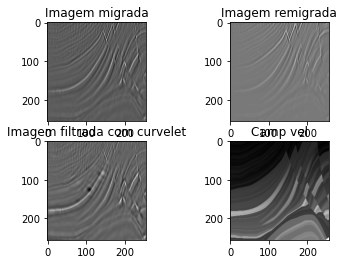

In [7]:
# Test to see if the input data are being read correctly
fig, axes = plt.subplots(2,2)
axes[0,0].imshow(migratedImg, cmap='gray')
axes[0,0].title.set_text("Imagem migrada")
axes[0,1].imshow(remigratedImg, cmap='gray')
axes[0,1].title.set_text("Imagem remigrada")
axes[1,0].imshow(curvFiltImg, cmap='gray')
axes[1,0].title.set_text("Imagem filtrada com curvelet")
axes[1,1].imshow(velocityField, cmap='gray')
axes[1,1].title.set_text("Camp vel")
plt.show()

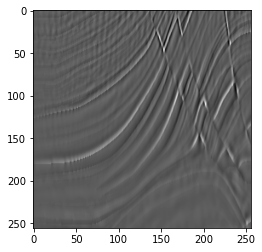

In [8]:
plt.imshow(migratedImg, cmap='gray')

In [9]:
# Normalazing the remigrated image
norm_remigratedImg = remigScaleModel.transform(remigratedImg)

# Normalazing the migrated image
norm_migratedImg = migScaleModel.transform(migratedImg)

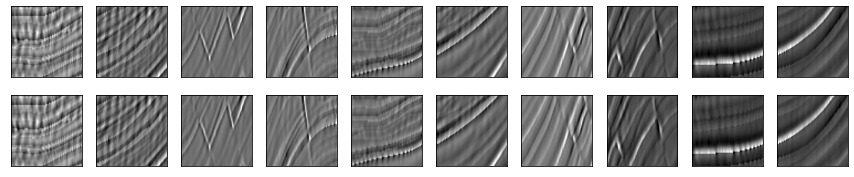

In [10]:
stride_z = 64
stride_x = 64

(z_max,x_max) = norm_migratedImg.shape

tiles_migratedImg = tile(norm_migratedImg, patch_size, stride_z, stride_x)

fig, axs = plt.subplots(2, 10, figsize=(15,3))

k = 0
for m in range(10):
  axs[0,m].imshow(tiles_migratedImg[k,:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
  axs[0,m].set_xticks([])
  axs[0,m].set_yticks([])
  k += 1

k = 0
for m in range(10):
  axs[1,m].imshow(tiles_migratedImg[k,:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
  axs[1,m].set_xticks([])
  axs[1,m].set_yticks([])
  k += 1

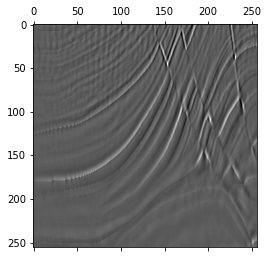

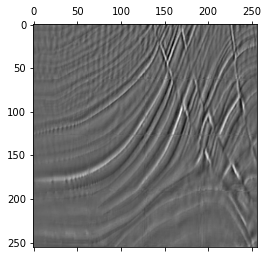

In [11]:
result_tiles = model.predict_on_batch(tiles_migratedImg)
norm_result = merge(result_tiles, z_max, x_max, patch_size, stride_z, stride_x)
result = migScaleModel.inverse_transform(norm_result[:,:,0])

plt.matshow(migratedImg, interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(result, interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.show()

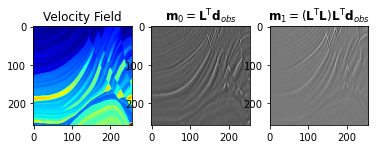

In [19]:
## Data plot
fig, axes = plt.subplots(1,3)
axes[0].imshow(velocityField, cmap='jet')
axes[0].title.set_text("Velocity Field")
axes[1].imshow(migratedImg, cmap='gray')
axes[1].title.set_text("$\mathbf{m}_0 = \mathbf{L}^\mathrm{T} \mathbf{d}_{obs}$")
axes[2].imshow(remigratedImg, cmap='gray')
axes[2].title.set_text("$\mathbf{m}_1 = (\mathbf{L}^\mathrm{T}\mathbf{L})\mathbf{L}^\mathrm{T} \mathbf{d}_{obs}$")
plt.savefig('results/inputdata.pdf', bbox_inches='tight')
plt.show()

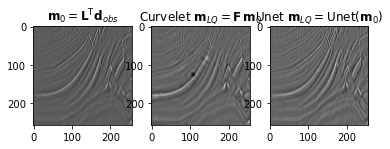

In [21]:
## Result plot
fig, axes = plt.subplots(1,3)
axes[0].imshow(migratedImg, cmap='gray')
axes[0].title.set_text("$\mathbf{m}_0 = \mathbf{L}^\mathrm{T} \mathbf{d}_{obs}$")
axes[1].imshow(curvFiltImg, cmap='gray')
axes[1].title.set_text("Curvelet $\mathbf{m}_{LQ} = \mathbf{F}\, \mathbf{m}_0$")
axes[2].imshow(result, cmap='gray')
axes[2].title.set_text("Unet $\mathbf{m}_{LQ} = \mathrm{Unet}(\mathbf{m}_0$)")
plt.savefig('results/resultsMarmousi.pdf', bbox_inches='tight')
plt.show()